---
title: 'Pre-Processing I: from XDF to raw files'
execute:
  warning: false
format: html
toc: true
---


Data for this experiment has been collected been collected using LabStreamLayer, allowing for recording of precisely synchronized streams (see [documentation](https://github.com/sccn/labstreaminglayer)). 

These streams include:
- Audio stream (16kHz)
- Webcam Frame stream (ca. 60 Hz)
- Marker stream (sent from custom buttonbox)
- Balance board stream (500 Hz)

LSL outputs single file in Extensible Data Format (XDF). This file contains all the data streams in form of a timeseries. In this script, we extract all the streams from the file and create raw (audio, video, and other) files for further processing.

Additionally, in this script, we
- correct faulty delimitations of trials
- align 16kHz LSL audio and external 48kHz audio that has been recorded outside of LSL, and cut this aligned audio to trial-sized files
- combine video and audio into single file


More information about the complete lab setup can be found in our previous preregistration where we archived list of all equipment and software used in the experiment. It is available here: https://osf.io/3nygq/

In [30]:
#| code-fold: true
#| code-summary: Code to prepare the environment

# import packages
import os
import pyxdf
import glob
import pandas as pd
import numpy as np
import wave, struct, random
from scipy.io import wavfile
import noisereduce as nr
import cv2
import matplotlib.pyplot as plt
from IPython.display import Audio, Video
import tempfile
import subprocess


# Set folders
curfolder = os.getcwd()

# If folder data doesn't exist, create it
if not os.path.exists(curfolder+'\\data\\'):
    os.makedirs(curfolder+'\\data\\')
datafolder = curfolder+'\\data\\'

# Also error_logs
if not os.path.exists(datafolder+'\\error_logs\\'):
    os.makedirs(datafolder+'\\error_logs\\')
errorlogs = datafolder+'\\error_logs\\'

experiment_to_process = curfolder + '\\..\\00_RAWDATA\\'

# Also CsvDataTS_raw
if not os.path.exists(datafolder+'\\Data_processed\\CsvDataTS_raw\\'):
    os.makedirs(datafolder+'\\Data_processed\\CsvDataTS_raw\\')
outputfolder = datafolder+'\\Data_processed\\CsvDataTS_raw\\' # outputfolder raw

# Audio in
if not os.path.exists(datafolder+'\\Data_processed\\CsvDataTS_raw\\Audio\\'):
    os.makedirs(datafolder+'\\Data_processed\\CsvDataTS_raw\\Audio\\')

# Also Data_trials
if not os.path.exists(datafolder+'\\Data_processed\\Data_trials\\'):
    os.makedirs(datafolder+'\\Data_processed\\Data_trials\\')
trialfolder = datafolder+'\\Data_processed\\Data_trials\\' # outputfolder trialbased


# Add audio in
if not os.path.exists(datafolder+'\\Data_processed\\Data_trials\\Audio\\'):
    os.makedirs(datafolder+'\\Data_processed\\Data_trials\\Audio\\')

# Get all the folders in the target folder
datafolders = glob.glob(experiment_to_process+'*\\')

# Extract the folder IDs
datafolders_id = [x.split('\\')[-2] for x in datafolders]

# print(curfolder)
# print(targetfolder)
print(datafolders_id)

# Identify all xdf files and all the associated triallist info
xdffiles = []
trialdatas = []

for i in datafolders_id:
    file = glob.glob(experiment_to_process+i+'\\*.xdf')
    trialfile = experiment_to_process+i+'\\'+i+'_results'+'.csv'
    trialdatas.append(trialfile)
    xdffiles.extend(file)

# These are the xdf files we need to process
print(xdffiles[0:10])
print(trialdatas[0:10])

['0_1', '0_2', 'Demographics_all']
['e:\\FLESH_ContinuousBodilyEffort\\01_XDF_processing\\..\\00_RAWDATA\\0_1\\session_S001.xdf', 'e:\\FLESH_ContinuousBodilyEffort\\01_XDF_processing\\..\\00_RAWDATA\\0_2\\session_S002.xdf']
['e:\\FLESH_ContinuousBodilyEffort\\01_XDF_processing\\..\\00_RAWDATA\\0_1\\0_1_results.csv', 'e:\\FLESH_ContinuousBodilyEffort\\01_XDF_processing\\..\\00_RAWDATA\\0_2\\0_2_results.csv', 'e:\\FLESH_ContinuousBodilyEffort\\01_XDF_processing\\..\\00_RAWDATA\\Demographics_all\\Demographics_all_results.csv']


# Extracting streams from XDF file

Using `pyxdf` package, we can extract the streams from the XDF file.

First, we extract streams for the whole recording session such that we end up with a file per each stream that represents the whole timeseries from the start to the end of the recording.

Then, we cut the whole streams into trial-sized chunks using the marker stream.Marker stream is saving presses from button box that has been administered by the experimentor. The presses indicates the start and end of each trial. We also collect the trial start and end time via the PsychoPy custom script that is used to run the experiment. We use this information to connect the marker to the trial metadata such as 
- what kind of concept is being performed
- is this trial baselina, correction 1, correction 2
- who performs this trial
- in which modality is this trial


(Note that this code takes some time to execute.)


In [14]:
#| code-fold: true
#| code-summary: Code with functions
#| eval: false

# Audio write function
def to_audio(fileloc, timeseries, samplerate = 16000, channels = 1):
    obj = wave.open(fileloc,'w')
    obj.setnchannels(channels) # mono
    obj.setsampwidth(2)
    obj.setframerate(float(samplerate))
    for i in timeseries:
        data = struct.pack('<h', int(i[0]))
        obj.writeframesraw( data )
    obj.close()

# Function to retrieve closest value
def find_closest_value_and_retrieve(df, target_number, target_column, retrieve_column):
    # Get the absolute differences between a value in column and the target number
    differences = abs(df[target_column] - target_number)
    
    # Find the index of the minimum difference
    min_difference_index = differences.idxmin()
    
    # Retrieve the corresponding value from the column
    result_value = df.loc[min_difference_index, retrieve_column]

    return result_value

def write_video(vidloc, fourcc, originalfps, frameWidth, frameHeight, capture, frames):
    out = cv2.VideoWriter(vidloc, fourcc, fps = originalfps, frameSize = (int(frameWidth), int(frameHeight)))
    #print('Looping over frames')

    # index the frames of the current trial 
    for fra in frames:
        capture.set(cv2.CAP_PROP_POS_FRAMES, fra)
        ret, frame = capture.read()
        if ret:
            out.write(frame)
            
        if not ret:
            print('a frame was dropped: ' + str(fra))
        
    capture.release()
    out.release()

In [ ]:
#| code-fold: false
#| code-summary: Code to extract streams from XDF files
#| eval: false

errorlist = []

for dat in datafolders_id:
    print('Loading in data from participant: ' + dat)
    trialdata = pd.read_csv(experiment_to_process+dat+'\\'+dat+'_results.csv', sep=",")
    #print(trialdata)
    
    # Get the xdf file
    files = glob.glob(experiment_to_process+dat+'\\*.xdf')
    streams, header = pyxdf.load_xdf(files[0])   
    # We go through each stream and save it as a csv
    for stream in streams:
        timeseriestype = stream['info']['name'][0]
        print(timeseriestype)
        samplerate = round(float(stream['info']['nominal_srate'][0]))
        # In the xdf loop over the streams and save it as csv if not yet exists
        channelcount = stream['info']['channel_count'][0]
        print('working on stream: ' + timeseriestype + '  with a channel count of ' + str(channelcount) +'\n and a sampling rate of ' + str(samplerate))
        timevec = stream['time_stamps']
        timeseries = stream['time_series']
        matrix_aux = np.vstack([np.transpose(timevec),np.transpose(timeseries)])
        matrix = np.transpose(matrix_aux)
        df_lab = pd.DataFrame(matrix)
        df_lab.to_csv(outputfolder+dat+'_'+timeseriestype+'_nominal_srate'+str(samplerate)+'.csv',index=False)
        # For audio stream also create a wav file
        if timeseriestype == 'Mic':
            wavloc = outputfolder+'Audio/'+dat+'_'+timeseriestype+'_nominal_srate'+str(samplerate)+'.wav'
            to_audio(wavloc, timeseries)
            # Load data
            rate, data = wavfile.read(wavloc)
            # Perform noise reduction
            reduced_noise = nr.reduce_noise(y=data, sr=rate, n_std_thresh_stationary=1.5,stationary=True)
            wavloc2 = outputfolder+'Audio/'+dat+'_'+timeseriestype+'_nominal_srate'+str(samplerate)+'_denoised.wav'
            wavfile.write(wavloc2, rate, reduced_noise)

        print('done with processing a complete time series and audio data')
        print('we will now start making trial snipped data') 

        # Load MyMarkerStream
        markers = pd.read_csv(outputfolder+dat+'_MyMarkerStream_nominal_srate0.csv')
        
        # Cut all timeseries to trial level based on the markers
        if timeseriestype != 'MyMarkerStream':
            
            beginlist = []
            endlist = []
            timestamps = []
            timestamps_2 = []
            tpose_starts = []
            tpose_ends = []

            # Iterate over markers and save times of trial starts and ends
            for row in markers.iterrows():
                if 'Trial_start' in row[1].iloc[1] or 'Practice trial starts' in row[1].iloc[1]:
                    beginlist.append(row[1].iloc[0])
                if 'Trial_end' in row[1].iloc[1] or 'Practice trial ends' in row[1].iloc[1]:
                    endlist.append(row[1].iloc[0])
                if 'Experiment_start' in row[1].iloc[1]:
                    timestamps.append(row[1].iloc[0])
                if 'New block starts' in row[1].iloc[1]:
                    timestamps_2.append(row[1].iloc[0])
                if 'Tpose starts' in row[1].iloc[1]:
                    tpose_starts.append(row[1].iloc[0])
                if 'Tpose ends' in row[1].iloc[1]:
                    tpose_ends.append(row[1].iloc[0])
                    
            # Converting coefficient for lsl to psychopy time
            exp_start_pp = float(trialdata['exp_start'][0])
            block_start_pp = float(trialdata['block_start'][0])
            
            # Get to lsl_to_pp coefficient
            if timestamps != []:
                lsl_to_pp = timestamps[0] - exp_start_pp
            else:
                lsl_to_pp = timestamps_2[0] - block_start_pp
        
            # Now we can proceed to cutting   
            for i in range(len(beginlist)):
                # Prepare the range of the trial
                begin = beginlist[i]
                end = endlist[i]
                indices = (df_lab.loc[:,0] > begin) & (df_lab.loc[:,0] < end)
                beginst = min(df_lab.loc[:,0]) # start time of the timeseries
                endst = max(df_lab.loc[:,0])  # end time of the timeseries
                subset = df_lab.loc[indices, :]
                # Convert the beginst to psychopy time
                beginst_pp = begin - lsl_to_pp
                # Now find in trialdata the closest time to the beginst_pp to gather info
                # Whether it is practice or trial
                practice = find_closest_value_and_retrieve(trialdata, beginst_pp, 'trial_start', 'practice')
                if practice == 'practice':
                    trialtype = 'pr'
                else:
                    trialtype = 'trial'
                
                # Which participant it is
                cycle = find_closest_value_and_retrieve(trialdata, beginst_pp, 'trial_start', 'cycle')
                if cycle == 0:
                    participant = 'p0'
                else:
                    participant = 'p1'

                # What concept it is
                word = find_closest_value_and_retrieve(trialdata, beginst_pp, 'trial_start', 'word')
                # Modality
                modality = find_closest_value_and_retrieve(trialdata, beginst_pp, 'trial_start', 'modality')
                # Correction, if applicable
                correction_info = find_closest_value_and_retrieve(trialdata, beginst_pp, 'trial_start', 'correction')
                if correction_info == 0:
                    correction = '_c0'
                elif correction_info == 1:
                    correction = '_c1'
                elif correction_info == 2:
                    correction = '_c2'
                else:
                    correction = ''
                
                # Continue saving
                if(len(subset.axes[0])<2):
                    errorlist.append(dat + " for "+ timeseriestype + " for trial " + str(i) + 'NO DATA WITHIN RANGE...')
                if(len(subset.axes[0])>2):
                     # Save subset to csv
                      subset.to_csv(trialfolder+dat+'_'+trialtype+'_'+ str(i) +'_'+timeseriestype+'_nominal_srate'+str(samplerate)+'_'+participant+'_'+word+'_'+modality+correction+'.csv', index=False)
                      if timeseriestype == 'Mic':
                            wavloc = trialfolder+'Audio/'+dat+'_'+trialtype+'_'+ str(i) +'_'+timeseriestype+'_nominal_srate'+str(samplerate)+'_'+participant+'_'+word+'_'+modality+correction+'.wav'
                            to_audio(wavloc, timeseries[indices])
                          # Also apply denoising
                            reduced_noiseclip = reduced_noise[indices]
                            wavloc2 = trialfolder+'Audio/'+dat+'_'+trialtype+'_'+ str(i) +'_'+timeseriestype+'_nominal_srate'+str(samplerate)+'_'+participant+'_'+word+'_'+modality+correction+'_denoised.wav'
                            wavfile.write(wavloc2, rate, reduced_noiseclip)
            
            # Get information about the tpose for camera
            if timeseriestype == 'MyWebcamFrameStream':
                for i in range(len(tpose_starts)):
                    begin = tpose_starts[i]
                    end = tpose_ends[i]
                    indices = (df_lab.loc[:,0] > begin) & (df_lab.loc[:,0] < end)
                    beginst = min(df_lab.loc[:,0])
                    endst = max(df_lab.loc[:,0])
                    subset = df_lab.loc[indices, :]
                    # Save subset to csv
                    subset.to_csv(trialfolder+dat+'_'+'tpose_'+ str(i) +'_'+timeseriestype+'_nominal_srate'+str(samplerate)+'.csv', index=False)
        
        # After every stream we'll save the error log
        errors = pd.DataFrame(errorlist, columns=['file_error'])
        # Get todays date
        today = pd.Timestamp("today").strftime("%Y_%m")
        file_path = errorlogs+'error_log_cuttingtrails' + today + '.csv'
        errors.to_csv(file_path, index=False) 
        
print('Were done: proceed to snipping videos to triallevel')

Now we have a csv file of a timeseries for each trial. The timeseries include 
- center of pressure (from the balance board stream)
- video frame number
- sound pressure (from the audio stream)

Here is an audio example of a trial:

In [ ]:
#| echo: false

wavfiles = glob.glob(trialfolder+'Audio\\*.wav')
# Keep only the denoised files
wavfiles = [x for x in wavfiles if 'denoised' in x]
# Pick random one
randomfile = random.choice(wavfiles)

Audio(randomfile)

Here is a visualization of center of pressure (all four channels) for a trial:

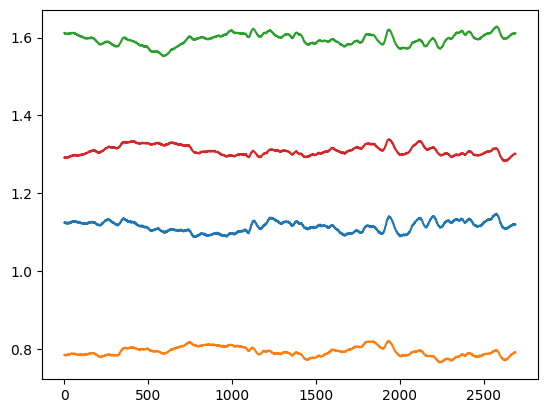

In [ ]:
#| echo: false

bbfiles = glob.glob(trialfolder+'*.csv')
# Keep only the denoised files
bbfiles = [x for x in bbfiles if 'Balance' in x]

# Pick random one
randomfile = random.choice(bbfiles)

# Plot the balance board data, first column is time, the rest is the data - plot them all
data = pd.read_csv(randomfile)

# Plot
plt.plot(data.iloc[:,1:])
plt.show()


# Writing video files

Now we have almost all data in desirable form. However, we still need to write videos for each trial because currently, we have only the frame numbers saved for each trial. 

We use these files to access the range of frames in the original raw video file for the whole session, and cut it out from it

You will notice that beside regular trial files, there is few files named 'tpose'. This is a specific kind of trial that preceeds the whole experiment. Before they start, participants are asked to stand straight with their arms extended to the side (so to resemble a T-shape). We use this video later for scaling a computational biomechanical model (see @ADDREFERENCE).

In [15]:
#| code-fold: true
#| code-summary: Code to prepare folders

# This is a folder with timeseries
tsfolder = datafolder+'\\Data_processed\\Data_trials\\'
# Keep only the csv files
tsfiles = glob.glob(tsfolder+'*.csv')
# This is where the raw long video is
videofolder = curfolder + '\\..\\00_RAWDATA\\'

In [ ]:
#| eval: false

# Loop through the csv's in tsfolder that has string 'MyWebcamStream' in name
for file in tsfiles:
    if 'MyWebcamFrameStream' in file:
        print('Now processing file '+ file)

        filename = file.split('\\')[-1].split('.')[0]

        # If it is a tpose file, the name looks a bit different
        if 'tpose' in filename:
            sessionIndex = filename.split('_')[0] + '_' + filename.split('_')[1]
            videoname = sessionIndex+'_tpose_'+filename.split('_')[3]

        else:
            # The name looks like this 0_1_trial_0_MyWebcamFrameStream_nominal_srate500_p0_bitter_geluiden.csv
            dyadIndex = filename.split('_')[0]   # this is dyad number
            partIndex = filename.split('_')[1]   # this is part of the session
            sessionIndex = dyadIndex + '_' + partIndex # this is the session index
            trialIndex = filename.split('_')[3] # this is trial number
            participant = filename.split('_')[7] # this is participant 0/1
            word = filename.split('_')[8] # this is the concept
            modality = filename.split('_')[9].split('.')[0] # this is the modality

            # Assess the correction
            if 'c0' in filename:
                correction = '_c0'
            elif 'c1' in filename:
                correction = '_c1'
            elif 'c2' in filename:
                correction = '_c2'
            else:
                correction = ''

            # Assess the trial type
            if 'pr' in file:
                trialtype = 'pr'
            else:
                trialtype = 'trial'

            # Get the filename
            videoname = sessionIndex+'_'+trialtype+'_'+ str(trialIndex) +'_'+participant+'_'+word+'_'+modality+correction

        trialdata = pd.read_csv(file)
        #print(trialdata)
        videolong = videofolder+sessionIndex+'\\'+sessionIndex+'-video.avi' # this is the long video 
        begin_time = trialdata['0'].min() # begin time of the trial
        end_time = trialdata['0'].max() # end time of the trial
        # Get the begin and end frame
        begin_frame = trialdata['1'].min().astype(int)
        end_frame = trialdata['1'].max().astype(int)
        totframes = end_frame-begin_frame # total number of frames in the trial
        frames = range(begin_frame, end_frame) # get all the frames in trial
        #print(frames)
        
        # Load in the long video
        capture = cv2.VideoCapture(videolong) 
        originalfps = round((totframes/(end_time-begin_time)),3) # original fps
        
        # This is the location where the video will be saved
        vidloc = trialfolder+videoname+'_video_raw'+'.avi'
        # Metadata
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        frameWidth = capture.get(cv2.CAP_PROP_FRAME_WIDTH)
        frameHeight = capture.get(cv2.CAP_PROP_FRAME_HEIGHT)

        # Start writing video
        print('Starting to write the video')
        write_video(vidloc, fourcc, originalfps, frameWidth, frameHeight, capture, frames)
        print('Video is done')

print('All done!')

Now processing file e:\FLESH_ContinuousBodilyEffort\01_XDF_processing\data\\Data_processed\Data_trials\0_1_pr_0_MyWebcamFrameStream_nominal_srate500_p0_bloem_geluiden.csv
Starting to write the video
Video is done
Now processing file e:\FLESH_ContinuousBodilyEffort\01_XDF_processing\data\\Data_processed\Data_trials\0_1_trial_3_MyWebcamFrameStream_nominal_srate500_p0_vechten_geluiden.csv
Starting to write the video
Video is done
Now processing file e:\FLESH_ContinuousBodilyEffort\01_XDF_processing\data\\Data_processed\Data_trials\0_1_trial_4_MyWebcamFrameStream_nominal_srate500_p0_ademen_geluiden.csv
Starting to write the video
Video is done
Now processing file e:\FLESH_ContinuousBodilyEffort\01_XDF_processing\data\\Data_processed\Data_trials\0_1_trial_5_MyWebcamFrameStream_nominal_srate500_p0_bijten_geluiden.csv
Starting to write the video
Video is done
Now processing file e:\FLESH_ContinuousBodilyEffort\01_XDF_processing\data\\Data_processed\Data_trials\0_1_trial_6_MyWebcamFrameStream_

KeyboardInterrupt: 

Now we have for each trial also a video.

Here is an example:

In [ ]:
#| echo: false

# Create a temporary folder
temp_dir = tempfile.mkdtemp()
print("Temporary folder created:", temp_dir)

# Define input and output paths
avifiles = glob.glob(trialfolder+'\\*.avi')
sample = random.choice(avifiles)
mp4_path = os.path.join(temp_dir, "converted_audiovideo.mp4")  # Save MP4 in temp folder

# Convert AVI to MP4 with video and audio
if not os.path.exists(mp4_path):
    subprocess.run([
        "ffmpeg", "-i", sample, 
        "-vcodec", "libx264", "-acodec", "aac", "-b:a", "192k",  # Ensure audio is included
        "-crf", "23", "-preset", "fast", mp4_path
    ])
    print("Video converted and saved to:", mp4_path)

# Display the video inside Jupyter Notebook
Video(mp4_path, embed=True, width=600)

Temporary folder created: C:\Users\kadava\AppData\Local\Temp\tmpjgh_2aib
Video converted and saved to: C:\Users\kadava\AppData\Local\Temp\tmpjgh_2aib\converted_audiovideo.mp4


This is how T-pose looks like:

In [ ]:
#| echo: false


# Create a temporary folder
temp_dir = tempfile.mkdtemp()
print("Temporary folder created:", temp_dir)

# Define input and output paths
avifiles = glob.glob(trialfolder+'\\*.avi')
# leave only tpose files
avifiles = [x for x in avifiles if 'tpose' in x]
sample = random.choice(avifiles)
mp4_path = os.path.join(temp_dir, "converted_audiovideo.mp4")  # Save MP4 in temp folder

# Convert AVI to MP4 with video and audio
if not os.path.exists(mp4_path):
    subprocess.run([
        "ffmpeg", "-i", sample, 
        "-vcodec", "libx264", "-acodec", "aac", "-b:a", "192k",  # Ensure audio is included
        "-crf", "23", "-preset", "fast", mp4_path
    ])
    print("Video converted and saved to:", mp4_path)

# Display the video inside Jupyter Notebook
Video(mp4_path, embed=True, width=600)

Temporary folder created: C:\Users\kadava\AppData\Local\Temp\tmpuql4jxac
Video converted and saved to: C:\Users\kadava\AppData\Local\Temp\tmpuql4jxac\converted_audiovideo.mp4


# Correcting some trials

As mentioned, trials are meant to be delimited by button box markers that are triggered by presses from experimentor. However, due to occasional errors (e.g., participants forgot to signal start of the trial), we need to visually inspect all trials, and correct the ones that are not properly delimited.

For each session, we create a separate csv file where we note the correct beginning and end frame (as shown in the video itself) of the wrongly delimited trials. Then we cut these new frames from the long video - similarly as we did for the regular trials. Lastly, to make sure that other timeseries are also corrected in order to be correctly synchronize, we assess the LSL time of the new frames and cut the corresponding audio and balance board data.


In [ ]:
#| code-fold: true
#| code-summary: Code with functions

# audio write function
def to_audio(fileloc, timeseries, samplerate = 16000, channels = 1):
    obj = wave.open(fileloc,'w')
    obj.setnchannels(channels) # mono
    obj.setsampwidth(2)
    obj.setframerate(float(samplerate))
    for i in timeseries:
        data = struct.pack('<h', int(i))
        obj.writeframesraw( data )
    obj.close()

def correct_file(i, begin, end, errorlog, ts, stream):
    # get the start and end of the corrected range of frames
    # begin = error['frame_begin'][i]
    # end = error['frame_end'][i]
    if stream == 'video':
        indexcol = 1
    else:
        indexcol = 0
    # cut from the ts everything that is below start and above end
    indices = (ts.iloc[:,indexcol] > begin) & (ts.iloc[:,indexcol] < end)
    #beginst = min(ts.iloc[:,1]) #start time of the timeseries
    #endst = max(ts.iloc[:,1])  #end time of the timeseries
    subset = ts.loc[indices, :]
    # save also the time of the first and last frame as new variables
    if stream == 'video':
        errorlog.loc[i, 'begin_time'] = subset.iloc[0,1]
        errorlog.loc[i, 'end_time'] = subset.iloc[len(subset)-1,1]

    #print(errorlog['end_time'][i])
    # save the new timeseries using the path of the video column with _corrected as appended
    file_name = errorlog.loc[i, stream]
    # replace .csv by _corrected.csv
    file_name = file_name.replace('.csv', '_corrected.csv')
    return errorlog, file_name, subset

In [ ]:
#| code-fold: true
#| code-summary: Code to prepare environment

datafolder = curfolder + '/data/Data_processed/Data_trials/'
errorfolder = datafolder + 'Handlock_error/' # here we store all the corrected frame ranges
timeseries = curfolder + '/data/Data_processed/CsvDataTS_raw/'

errorfiles = glob.glob(errorfolder+'*.csv')

This is how the error file looks like:

In [ ]:
#| echo: false

error = pd.read_csv(errorfiles[0])
error.head(15)

In [ ]:
#| code-fold: true
#| code-summary: Code to correct some faulty trials

for file in errorfiles:
    # load the df
    error = pd.read_csv(file)
    session = file.split('\\')[-1].split('_')[0]

    # make new columns audio, video and bb
    error['audio'] = ''
    error['video'] = ''
    error['bb'] = ''

    # now let's find corresponding wrong files in audio and video
    audio = datafolder + 'Audio/'
    csv = glob.glob(datafolder + '*.csv')

    # loop over the error words
    for i in range(len(error)):
        # get the word
        word = error['word'][i]
        # get the part
        part = error['part'][i]
        # if the correction is not NaN, get it and transform to integer
        if pd.isna(error['correction'][i]) == False:
            correction = int(error['correction'][i])
            # if correction is 0, it is c0
            if correction == 0:
                correction = 'c0'
            elif correction == 1:
                correction = 'c1'
            else:
                correction = 'c2'
            
            part = '2'
            sessionID = session + '_' + part

        else:
            correction = ''
            part = '1'
            sessionID = session + '_' + part

        # loop over the csv files
        for j in range(len(csv)):
            # if the word is in the csv file
            if word in csv[j] and sessionID in csv[j] and correction in csv[j]:
                # get the corresponding csv file
                csv_file = csv[j]
                # if the file has Mic in it, save its name to column audio
                if 'Mic' in csv_file:
                    error.loc[i, 'audio'] = csv_file
                # if the file has Webcam in it, save its name to column video
                elif 'Webcam' in csv_file:
                    error.loc[i, 'video'] = csv_file
                # if BalanceBoard in it, save its name to column bb
                elif 'BalanceBoard' in csv_file:
                    error.loc[i, 'bb'] = csv_file


    # create begin_time and end_time columns
    error['begin_time'] = 0.0
    error['end_time'] = 0.0

    ########################## re-cutting csv files ##############################

    # now we will get to each timeseries, and correct the frame/time range
    csv_ts = glob.glob(timeseries + '*.csv')

    webcam_ts = [x for x in csv_ts if 'Webcam' in x]
    mic_ts = [x for x in csv_ts if 'Mic_nominal' in x]
    bb_ts = [x for x in csv_ts if 'BalanceBoard' in x]
    
    # loop over the error words
    for i in range(len(error)):
        print(error['word'][i])
        # if the session is 0_1 load 0_1_MyWebcamFrameStream
        if error['part'][i] == 1:
            sessionID = session + '_1'
            webcam_ts = timeseries + sessionID + '_MyWebcamFrameStream_nominal_srate500.csv'
            ts_w = pd.read_csv(webcam_ts)
            mic_ts = timeseries + sessionID + '_Mic_nominal_srate16000.csv'
            ts_m = pd.read_csv(mic_ts)
            bb_ts = timeseries + sessionID + '_BalanceBoard_stream_nominal_srate500.csv'
            ts_bb = pd.read_csv(bb_ts)
        elif error['part'][i] == 2:
            sessionID = session + '_2'
            webcam_ts = timeseries + session + '_2_MyWebcamFrameStream_nominal_srate500.csv'
            ts_w = pd.read_csv(webcam_ts)
            mic_ts = timeseries + sessionID + '_Mic_nominal_srate16000.csv'
            ts_m = pd.read_csv(mic_ts)
            bb_ts = timeseries + sessionID + '_BalanceBoard_stream_nominal_srate500.csv'
            ts_bb = pd.read_csv(bb_ts)
            # get the start and end of the corrected range of frames
            begin = error['frame_begin'][i]
            end = error['frame_end'][i]

        # video correction 
        begin = error['frame_begin'][i]
        end = error['frame_end'][i]
        error, file_name, subset = correct_file(i, begin, end, error, ts_w, 'video')
        if len(subset) == 0:
            print('This file is empty: ' + error['video'][i])
        else:
            # save also the begin_time and end_time
            error.loc[i, 'begin_time'] = subset.iloc[0,0]
            error.loc[i, 'end_time'] = subset.iloc[len(subset)-1,0]
            subset.to_csv(file_name, index = False)  

        # audio correction
        begin_time = error.loc[i, 'begin_time']
        end_time = error.loc[i, 'end_time']
        error, filename, subset = correct_file(i, begin_time, end_time, error, ts_m, 'audio')
        if len(subset) == 0:
            print('This file is empty: ' + error['audio'][i])
        else:
            subset.to_csv(filename, index = False)
            
        # balanceboard correction
        error, filename, subset = correct_file(i, begin_time, end_time, error, ts_bb, 'bb')
        if len(subset) == 0:
            print('This file is empty: ' + error['bb'][i])
        else:
            subset.to_csv(filename, index = False)
    
    ################### rewriting audio and video ############################

    # get all the csv files with _corrected in it
    correct = glob.glob(datafolder + '*_corrected.csv')
    audio = datafolder + 'Audio/'
        
    # loop over them 
    for i in range(len(correct)):
        print(correct[i])
        sessionID = correct[i].split('\\')[-1].split('_')[0] + '_' + correct[i].split('\\')[-1].split('_')[1]

        # if it has Mic in it, create an audio
        if 'Mic' in correct[i]:
            file_name = correct[i]
            # take only the last part of the path
            file_name = file_name.split('\\')[-1]
            # replace _corrected.csv by .wav
            file_name = file_name.replace('.csv', '.wav')          
            print(file_name)
            wavloc = audio+file_name
            ts = pd.read_csv(correct[i])
            # make second column into a list
            sound = ts.iloc[:,1].tolist()
            to_audio(wavloc, sound)
            # load data    
            rate, data = wavfile.read(wavloc)
            # perform noise reduction
            reduced_noise = nr.reduce_noise(y=data, sr=rate, n_std_thresh_stationary=1.5,stationary=True)
            file_name2 = file_name.replace('.wav', '_denoised.wav')
            wavloc2 = audio + file_name2
            wavfile.write(wavloc2, rate, reduced_noise)

        # if it has webcam in it, create a video
        elif 'Webcam' in correct[i]:
            print('This is a video')
            ts = pd.read_csv(correct[i])
            videolong = experiment_to_process+ '\\' + sessionID + '\\' + sessionID + '-video.avi'
            print(videolong)
            begin_time = ts['0'].min() # begin time of the trial
            end_time = ts['0'].max() # end time of the trial
            # get the begin and end frame
            begin_frame = ts['1'].min().astype(int)
            end_frame = ts['1'].max().astype(int)
            totframes = end_frame-begin_frame # total number of frames in the trial
            frames = range(begin_frame, end_frame) #get all the frames in trial
            #load in the long video
            print('Loading the original video')
            capture = cv2.VideoCapture(videolong) 
            originalfps = round((totframes/(end_time-begin_time)),3)
            print('original fps: '+str(originalfps))
            
            # filename
            filename = correct[i].split('\\')[-1]
            # replace MyWebcamFrameStream_nominal_srate500_ with ''
            filename = filename.replace('MyWebcamFrameStream_nominal_srate500_', '')
            # replace csv. with ''
            filename = filename.replace('.csv', '')
            # this is the location where the video will be saved
            vidloc = datafolder + filename + '_video_raw' + '.avi'
            # video metadata
            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            frameWidth = capture.get(cv2.CAP_PROP_FRAME_WIDTH)
            frameHeight = capture.get(cv2.CAP_PROP_FRAME_HEIGHT)
            # start writing video
            print('Starting to write the video')
            write_video(vidloc, fourcc, originalfps, frameWidth, frameHeight, capture, frames)
        else:
            print('BB do not need any processing')

    print('All streams have been corrected')

Now we have all the data streams (i.e., audio, video, balance board) as single csv file per trial wherein each trial correctly starts with the beginning of the performance and capture the whole behaviour until the end of the performance.

Additionally, we also have wav file for each trial and a video file for each trial.

# Aligning high-sampling audio and cutting it to trial-sized files

Alongside the 16kHz audio stream that is recorded within LSL, we have also recorded additional 48kHz audio from the same source (see [method preregistration](https://osf.io/3nygq)). 

However, this audio is not natively synchronized with the rest of the data. However, because both audios come from the same source and record the same event, we can align them using cross-correlation.


In [ ]:
#| code-fold: true
#| code-summary: Code to load packages and prepare the environment

from __future__ import print_function
from shign import shift_align
import numpy as np
import wave
import soundfile as sf
import noisereduce as nr
from scipy.io import wavfile

audio_48 = experiment_to_process
audio_48_files = glob.glob(audio_48 + '**/*.wav', recursive=True)
audio_16 = curfolder + '\\data\\Data_processed\\CsvDataTS_raw\\Audio\\'
audio_16_files = glob.glob(audio_16 + '*denoised.wav')

We will use `shign` package (see [Github](https://github.com/KnurpsBram/shign)) that defines time shift of the two audios by looking at the amount of shift that maximizes the correlation between loudness envelopes of the audios.

Before aligning the audios, we first denoise the 48kHz audio and downsample it to 16kHz to match the LSL audio. Then we use the `shift_aling` function from the `shign` package to align the audios.

In [ ]:
#| code-fold: false
#| code-summary: Code to align two audios
#| eval: false

for file48 in audio_48_files:
    print('working on' + file48)
    # get session ID
    sessionID = file48.split('\\')[-1].split('.')[0].split('_')[0] + '_' + file48.split('\\')[-1].split('.')[0].split('_')[1]
    # find the corresponding 16kHz file
    file16 = [x for x in audio_16_files if sessionID in x][0]
    print('corresponding file:' + file16)

    # first we reduce noise in the 48kHz file
    rate, data = wavfile.read(file48)
    reduced_noise = nr.reduce_noise(y=data, sr=rate, n_std_thresh_stationary=1.5,stationary=True)#
    # replace .wav by _denoised.wav
    wavloc2 = file48.replace('.wav', '_denoised.wav')
    wavfile.write(wavloc2, rate, reduced_noise)

    # now open the new denoised file
    file48_newpath = wavloc2
    audio48_new = wave.open(file48_newpath, 'rb')
    audio16 = wave.open(file16, 'rb')

    # get both audio files  
    audio_data1 = np.frombuffer(audio16.readframes(-1), dtype=np.int16)
    sample_rate1 = audio16.getframerate()
    audio_data2 = np.frombuffer(audio48_new.readframes(-1), dtype=np.int16)
    sample_rate2 = audio48_new.getframerate()

    print(sample_rate1, sample_rate2)

    my_aligned_audio1, my_aligned_audio2 = shift_align(audio_a=file16, audio_b=file48_newpath, sr_a=16000, sr_b=48000, align_how='pad_and_crop_one_to_match_other')

    # save the output
    wav2_path = file48_newpath.replace('.wav', '_aligned.wav')
    sf.write(wav2_path, my_aligned_audio2, 48000)

In [ ]:
#| code-fold: true
#| code-summary: Code with functions

def find_closest_rows(df, target_number):
    # Calculate the absolute difference between each value in the 'trial_start' column and the target number
    df['abs_difference'] = abs(df.iloc[:, 0] - target_number)
    
    # Find the row with the smallest absolute difference for each row
    closest_rows = df[df['abs_difference'] == df['abs_difference'].min()]

    return closest_rows

Now we have 48kHz audio that is aligned with the rest of the data collected via LSL. In order to be able to use this audio in further processing, we too cut it to trial-sized files.

Because both audio streams have stable sampling rate, we can simply use the trial-sized files of the 16Khz audio, find their indices in the whole-session timeseries we created earlier, apply a conversion coefficient to the indices delimiting this trial to get the indices for the 48kHz audio, and cut the 48kHz audio accordingly.

The conversion coeeficient is sr2/sr1, where sr1 is the sampling rate of the 16kHz audio and sr2 is the sampling rate of the 48kHz audio. In our case sr1=16000 and sr2=48000, so the conversion coefficient is 3.

In [ ]:
#| code-fold: false
#| code-summary: Code to cut audio to trial level
#| eval: false

# setup folders
audio_48_files = glob.glob(experiment_to_process + '**/*aligned.wav', recursive=True)
ts_audio = curfolder + '\\data\\Data_processed\\CsvDataTS_raw\\'

# get the whole-session audio timeseries
csvfiles = glob.glob(ts_audio + '*.csv')
ts_audio_files = [x for x in csvfiles if 'Mic' in x] # keep only those that have Mic

# get trial-sized audio timeseries
trials = curfolder + '\\data\\Data_processed\\Data_trials\\'
csvfiles = glob.glob(trials + '*.csv')
ts_audio_trials = [x for x in csvfiles if 'Mic' in x] # keep only those that have Mic

# here we will store the new audio
audio_trials_48 = curfolder+'\\data\\Data_processed\\Data_trials\\Audio_48'

# this is our coefficient
convert = 3 # 48000/16000

for file in ts_audio_files:
    print('working on' + file)
    # get session ID
    sessionID = file.split('\\')[-1].split('.')[0].split('_')[0] + '_' + file.split('\\')[-1].split('.')[0].split('_')[1]

    # find the corresponding 48kHz file
    file48 = [x for x in audio_48_files if sessionID in x][0]
    print('corresponding file: ' + file48)

    # open audio
    audio48 = wave.open(file48, 'rb')
    data48 = np.frombuffer(audio48.readframes(-1), dtype=np.int16)

    # open the csv file
    ts_audio = pd.read_csv(file)

    # now get all files that are in ts_audio_files and have same sessionID
    audiotrials = [x for x in ts_audio_trials if sessionID in x]

    for trial in audiotrials:
        print('working on trial: ' + trial)
        # open the csv file
        df = pd.read_csv(trial)

        # first and last value
        start = df.iloc[0, 0]
        end = df.iloc[len(df)-1, 0]

        # find the closest row in ts_audio
        closest_row_start = find_closest_rows(ts_audio, start)
        start_index = closest_row_start.index[0]    
        closest_row_end = find_closest_rows(ts_audio, end)
        end_index = closest_row_end.index[0]

        # convert
        start_index_2 = start_index*convert
        end_index_2 = end_index*convert
        print('new indices ', start_index_2, end_index_2)

        # cut the data48
        data2_trial = data48[int(start_index_2):int(end_index_2)]
        filename_new = trial.split('\\')[-1].split('.')[0]
        # replace 16000 with 48000
        filename_new = filename_new.replace('16000', '48000')
        file_path = audio_trials_48 + '\\' + filename_new + '.csv'
        # save the csv to audio_48
        df = pd.DataFrame(data2_trial)
        df.to_csv(file_path, index=False)

        # now to audio
        wavloc = audio_trials_48 + '\\' + filename_new + '.wav'
        to_audio(wavloc, data2_trial, samplerate = 48000)

This is an example of the newly cut 48kHz audio

In [29]:
#| echo: false

audio_trials_48 = curfolder+'\\data\\Data_processed\\Data_trials\\Audio_48\\'
# Get wav files
wavfiles = glob.glob(audio_trials_48 + '*.wav')
# Pick random one
randomfile = random.choice(wavfiles)

Audio(randomfile)

# Concatenating audio and video

We do not necessarilly need to have video and audio combined, but we do want to check whether they are synchronized. They should be if LSL is working correctly, but it's always good to do a sanity check as LSL can be sensitive to CPU-overload and other issues.

We will combine the audio and video for each trial using `ffmpeg` package, and save it as a new video file.

In [20]:
#| code-fold: false
#| code-summary: Code to prepare environment

import ffmpeg

wavloc = trialfolder+'Audio_48\\'
wavfiles = glob.glob(wavloc+'*.wav')
audiovideo = datafolder+'Data_processed\\AudioVideo\\'
videofolder = datafolder+'Data_processed\\Data_trials\\'

In [ ]:
#| code-fold: false
#| code-summary: Code to combine audio with video for each trial
#| eval: false

# loop over Audio files
for file in wavfiles:

    print('Now processing file '+file)

    filename = file.split('\\')[-1].split('.')[0]

    dyadIndex = filename.split('_')[0]   # this is dyad number
    partIndex = filename.split('_')[1]   # this is part of the session
    sessionIndex = dyadIndex + '_' + partIndex # this is the session index
    print(sessionIndex)
    trialIndex = filename.split('_')[3] # this is trial number

    participant = filename.split('_')[7] # this is participant 0/1
    word = filename.split('_')[8] # this is the word
    modality = filename.split('_')[9] # this is the modality

    # handle correction
    if 'c0' in file:
        correction = '_c0'
    elif 'c1' in file:
        correction = '_c1'
    elif 'c2' in file:
        correction = '_c2'
    else:
        correction = ''
    # trial type
    if '_pr_' in file:
        trialtype = 'pr'
    else:
        trialtype = 'trial'

    # if it's corrected file or not
    if 'corrected' in file:
        add = '_corrected'
    else:
        add = ''

    #load in the audio
    print('Loading the audio')
    audio_path = os.path.join(wavloc, file)
    if not os.path.exists(audio_path):
        print(f"Audio file not found: {audio_path}")

    # input the video with ffmpg
    input_audio = ffmpeg.input(audio_path)
    print(input_audio)
    #load in the video with matchich trialIndex and SessionIndex
    print('Loading the video')
    video_path = os.path.join(videofolder + f"{sessionIndex}_{trialtype}_{trialIndex}_{participant}_{word}_{modality}{add}{correction}_video_raw.avi")

    if not os.path.exists(video_path):
        print(f"Video file not found: {video_path}")
    input_video = ffmpeg.input(video_path)
    print(input_video)
    
    #combine the audio and video
    print('Combining audio and video')
    output_path = os.path.abspath(os.path.join(audiovideo, f"{sessionIndex}_{trialtype}_{trialIndex}_{participant}_{word}_{modality}{correction}_final.avi"))
    ffmpeg.concat(input_video, input_audio, v=1, a=1).output(
        output_path,
        vcodec='libx264',
        acodec='aac',
        video_bitrate='2M',         
        
        ).run(overwrite_output=True)
    
print('All done!')

Here is an example of the combined audio and video for a trial

In [ ]:
#| echo: false

# Create a temporary folder
temp_dir = tempfile.mkdtemp()
print("Temporary folder created:", temp_dir)

# Define input and output paths
avifiles = glob.glob(audiovideo+'*.avi')
sample = random.choice(avifiles)
mp4_path = os.path.join(temp_dir, "converted_audiovideo.mp4")  # Save MP4 in temp folder

# Convert AVI to MP4 with video and audio
if not os.path.exists(mp4_path):
    subprocess.run([
        "ffmpeg", "-i", sample, 
        "-vcodec", "libx264", "-acodec", "aac", "-b:a", "192k",  # Ensure audio is included
        "-crf", "23", "-preset", "fast", mp4_path
    ])
    print("Video converted and saved to:", mp4_path)

# Display the video inside Jupyter Notebook
Video(mp4_path, embed=True, width=600)

Temporary folder created: C:\Users\kadava\AppData\Local\Temp\tmpgh9gqck9
Video converted and saved to: C:\Users\kadava\AppData\Local\Temp\tmpgh9gqck9\converted_audiovideo.mp4
